# Magazine Visualization
We will be continuing our investigation of representation in magazines
by visualizing the data that we collected!

Let's get started!

In [ ]:
#@title <-- Import Libraries
# Used to hold data and for plotting
import pandas as pd
import plotly.express as px
import plotly.io as pio
import json

def is_json(json_string):
  """Test if a string is valid JSON."""
  try:
    json.loads(json_string)
  except ValueError as e:
    return False
  return True

def load_student_data(student_string):
  """Tries to parse student string or fix common issues.""" 
  if is_json(student_string):
    return pd.read_json(student_string)
  elif is_json("{" + student_string):
    return pd.read_json("{" + student_string)
  elif is_json(student_string + "}"):
    return pd.read_json(student_string + "}")
  else:
    return None

## Load our points.
Grab the text representation of points that you previously collected in the previous colab and lets load the dataframe here.

In [ ]:
datasets = {}
while True:
  dataset_name = input("What category are these datapoints from? (Hit return when done)")
  if not dataset_name:
    break
  article_data = load_student_data(input("Input your point string representation: "))
  if article_data is not None:
    if 'color' not in article_data.columns:
      article_data['color'] = article_data.apply(lambda row: f'rgb({row["red"]},{row["green"]},{row["blue"]})')
    datasets[dataset_name] = article_data
  else:
    print(f"Error with dataset {dataset_name}")

# Create a combined dataset.
combined_datasets = pd.DataFrame()
for _, points in datasets.items():
  combined_datasets = combined_datasets.append(points, ignore_index=True)
datasets['combined'] = combined_datasets

What category are these datapoints from? (Hit return when done)Male
Input your point string representation: {"red":{"0":214.0,"1":217.0,"2":223.0},"green":{"0":169.0,"1":178.0,"2":198.0},"blue":{"0":149.0,"1":150.0,"2":178.0},"color":{"0":"rgb(214,169,149)","1":"rgb(217,178,150)","2":"rgb(223,198,178)"}}
What category are these datapoints from? (Hit return when done)Female
Input your point string representation: {"red":{"0":102.0,"1":89.0,"2":87.0,"3":159.0,"4":145.0,"5":173.0,"6":241.0,"7":226.0,"8":173.0,"9":144.0,"10":135.0,"11":197.0,"12":146.0,"13":97.0,"14":126.0,"15":111.0,"16":69.0,"17":54.0,"18":181.0,"19":142.0,"20":152.0,"21":164.0,"22":162.0,"23":160.0,"24":165.0,"25":148.0,"26":165.0,"27":175.0,"28":172.0,"29":185.0,"30":167.0,"31":166.0,"32":167.0,"33":159.0,"34":156.0,"35":142.0},"green":{"0":71.0,"1":68.0,"2":66.0,"3":91.0,"4":74.0,"5":102.0,"6":195.0,"7":165.0,"8":115.0,"9":97.0,"10":95.0,"11":144.0,"12":112.0,"13":62.0,"14":87.0,"15":94.0,"16":54.0,"17":49.0,"18":100.

# Visualize
Let's visualize these points again in 3D space! Make sure they are the same as last week. What trends/clusters do you notice?

In [ ]:
# Import plotly - a library for graphing in python
import plotly.graph_objects as go

def create_3d_scatter(selected_points, plt_name):
  fig = go.Figure()

  # Create 3D scatter plot.
  fig.add_trace(dict(type='scatter3d',
                x=selected_points['red'],
                y=selected_points['green'],
                z=selected_points['blue'],
                mode='markers',
                marker=dict(color=list(selected_points['color']),
                            size=10)))

  # Set axis labels and dimensions.
  fig.update_layout(
      title = plt_name,
      scene = dict(
                    xaxis_title='RED',
                    yaxis_title='GREEN',
                    zaxis_title='BLUE',
                    xaxis = dict(nticks=4, range=[0,255],),
                    yaxis = dict(nticks=4, range=[0,255],),
                    zaxis = dict(nticks=4, range=[0,255],))) 
  return fig  
for dataset_name, points in datasets.items():
  fig = create_3d_scatter(points, dataset_name)
  pio.show(fig)

# Cluster
Let's use a clustering algorithm (K-Means) to figure out what 5 skin tones best represent all points in the data.

In [ ]:
# Import scikit-learn, a machine learning library.
from sklearn.cluster import KMeans

# Load our classifier. 
num_clusters = 5 # You can change this if you want more/less than 5 bins!

# Fit to our data.
clusters_by_set = {}
for dataset_name, points in datasets.items():
  kmeans_cluster = KMeans(n_clusters=num_clusters, random_state=0)
  clusters_by_set[dataset_name] = kmeans_cluster.fit(points[['red','green','blue']])

## Explore the clusters!

Take a look at how our clusters look in space. They are the 5 red points
connected by lines.

*   What do you notice?
*   Do these seem representative?
*   Are any points misclassified?

In [ ]:
# Add cluster centers to scatter.
for dataset_name, points in datasets.items():
  clusters = pd.DataFrame(clusters_by_set[dataset_name].cluster_centers_,
                          columns=['red','green','blue'])
  fig = create_3d_scatter(points, dataset_name)
  # Maybe connect all points to their cluster?
  fig.add_trace(dict(type='scatter3d',
            x=clusters['red'],
            y=clusters['green'],
            z=clusters['blue'])
            )
  pio.show(fig)

## Let's look at the relative frequencies of each cluster!

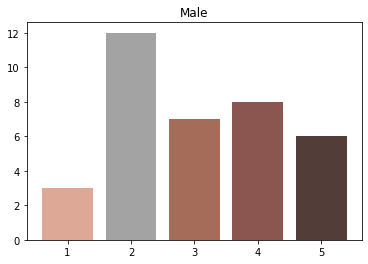

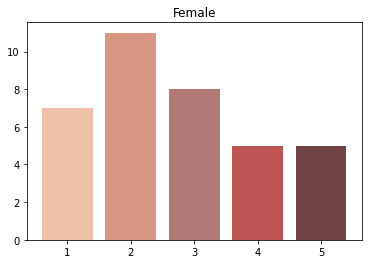

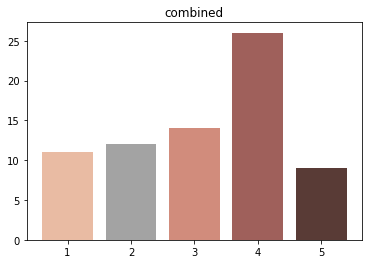

In [ ]:
for dataset_name, points in datasets.items():
  kmeans_cluster = clusters_by_set[dataset_name]
  # Turn cluster centers into a color and sort by hue.
  cluster_center_colors = []

  def luminance_of_color(r,g,b):
    """ Luminance is a perceived brightness of an RGB color. """
    return 0.2126*r + 0.7152*g + 0.0722*b
  cluster_center_order = []
  cluster_center_order_map = {}

  # Loop through each colors
  for current_index, color in enumerate(kmeans_cluster.cluster_centers_):
    r, g, b = color
    color_tuple = (int(r)/255,int(g)/255,int(b)/255)
    # Add the color to the bin.
    cluster_center_colors.append((
        luminance_of_color(r,g,b),
        current_index,
        (int(r)/255,int(g)/255,int(b)/255)
    ))
    cluster_center_order.append((r**2 + g**2 + b**2, len(cluster_center_order)))
  # Create mapping from original index order to new sorted cluster.
  cluster_colors = []
  for new_index, ordering in enumerate(sorted(cluster_center_colors, reverse=True)):
    _, old_index, color, = ordering
    cluster_colors.append(color)
    cluster_center_order_map[old_index] = new_index

  # Count number of points in each cluster.
  tones_by_clusters = kmeans_cluster.predict(points[['red','green','blue']])
  cluster_counts = [0] * num_clusters
  for x in tones_by_clusters:
    cluster_counts[cluster_center_order_map[x]] += 1

  # Visualize.
  import matplotlib.pyplot as plt 
  plt.bar(list(range(1, num_clusters + 1)), cluster_counts, color=cluster_colors)
  plt.title(dataset_name)
  plt.show()